In [1]:
from asgardpy.analysis import AsgardpyAnalysis
from asgardpy.config import AsgardpyConfig
from gammapy.modeling.models import Models
from gammapy.data import DataStore

import matplotlib.pyplot as plt
import numpy as np

import astropy.units as u
import logging

In [2]:
from asgardpy.data.dataset_1d import Dataset1DGeneration
from asgardpy.io.io import DL3Files

In [3]:
log = logging.getLogger("test 1d dataset")

In [4]:
base_dir = "/fefs/aswg/workspace/chaitanya.priyadarshi/"
config_file = base_dir + "analyze_crab_test_Nov2020.yaml"

In [5]:
config = AsgardpyConfig()

In [6]:
%%time
config_main = config.read(config_file)

CPU times: user 49.8 ms, sys: 2.19 ms, total: 52 ms
Wall time: 49.5 ms


In [7]:
for g in config_main.general:
    print(g)

('log', LogConfig(level='info', filename=None, filemode=None, format=None, datefmt=None))
('outdir', '/fefs/aswg/workspace/chaitanya.priyadarshi/real_data/AGN/Crab/v09x/tailcut84/DL3/interp_irf_en_dep/nsb_tuning/geff_70/teff_70/20220518_dec2276/perf_paper/interp_w_23/joint_lat_lst/')
('n_jobs', 1)
('steps', [<AnalysisStepEnum.datasets_3d: 'datasets-3d'>, <AnalysisStepEnum.datasets_1d: 'datasets-1d'>, <AnalysisStepEnum.fit: 'fit'>, <AnalysisStepEnum.flux_points: 'flux-points'>])
('overwrite', True)
('stacked_dataset', True)


# Steps mentioned in the main config file

In [8]:
config_main.general.steps

[<AnalysisStepEnum.datasets_3d: 'datasets-3d'>,
 <AnalysisStepEnum.datasets_1d: 'datasets-1d'>,
 <AnalysisStepEnum.fit: 'fit'>,
 <AnalysisStepEnum.flux_points: 'flux-points'>]

# Target source information

In [9]:
for c in config_main.target:
    print(c)

('source_name', 'Crab')
('sky_position', SkyCoordConfig(frame=<FrameEnum.icrs: 'icrs'>, lon=<Angle 83.63308333 deg>, lat=<Angle 22.0145 deg>))
('use_uniform_position', True)
('models_file', None)
('extended', False)
('components', SkyModelComponent(name='Crab', type='SkyModel', spectral=SpectralModelConfig(model_name='LogParabola', type='LogParabolaSpectralModel', parameters=[ModelParams(name='amplitude', value=1e-06, unit='cm-2 s-1 TeV-1', error=1.5e-07, min=1e-13, max=0.01, frozen=False), ModelParams(name='reference', value=0.1, unit='TeV', error=0.0, min=0.0001, max=100.0, frozen=True), ModelParams(name='alpha', value=2.0, unit='', error=0.1, min=0.5, max=5.0, frozen=False), ModelParams(name='beta', value=0.01, unit='', error=0.001, min=1e-06, max=1.0, frozen=False)], ebl_abs=EBLAbsorptionModel(model_name='dominguez', type='EBLAbsorptionNormSpectralModel', redshift=0.0, alpha_norm=1.0)), spatial=SpatialModelConfig(model_name=None, type=None, parameters=[ModelParams(name=None, value=

# 1D Datasets informations

In [10]:
for cc in config_main.dataset1d:
    print(cc)

('type', <ReductionTypeEnum.spectrum: '1d'>)
('instruments', [Dataset1DBaseConfig(name='LST-1', io=[InputConfig(type='lst-1', input_dir=PosixPath('/fefs/aswg/workspace/chaitanya.priyadarshi/real_data/AGN/Crab/v09x/tailcut84/DL3/interp_irf_en_dep/nsb_tuning/geff_70/teff_70/20221027_v0.9.9_crab_tuned/cos_zen/joint_fit/LST1/Nov2020'), glob_pattern={'dl3': '202*/dl3*fits'})], dataset_info=Dataset1DInfoConfig(name='LST-1', geom=GeomConfig(wcs=WcsConfig(skydir=SkyCoordConfig(frame=None, lon=None, lat=None), binsize=<Angle 0.02 deg>, final_frame=FinalFrameConfig(width=<Angle 5. deg>, height=<Angle 5. deg>), binsize_irf=<Angle 0.2 deg>), selection=SelectionConfig(offset_max=<Angle 2.5 deg>), axes=EnergyAxesConfig(energy=EnergyAxisConfig(min=<Quantity 10. GeV>, max=<Quantity 100. TeV>, nbins=5), energy_true=EnergyAxisConfig(min=<Quantity 10. GeV>, max=<Quantity 100. TeV>, nbins=5))), observation=ObservationsConfig(obs_ids=[], obs_file=None, obs_time=TimeIntervalsConfig(format=<TimeFormatEnum.is

In [11]:
%%time
analysis = AsgardpyAnalysis(config_main)

Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}


CPU times: user 1.65 ms, sys: 0 ns, total: 1.65 ms
Wall time: 1.44 ms


In [12]:
analysis

# Prepare for a single 1D Dataset, based on instrument

In [13]:
instruments_list = config_main.dataset1d.instruments
print(len(instruments_list), "number of 1D dataset information provided")

config_1d_dataset = instruments_list[0]
print(f"Instrument selected is {config_1d_dataset.name}")

1 number of 1D dataset information provided
Instrument selected is LST-1


# Run each Dataset1DGeneration step

In [14]:
%%time
generate_1d_dataset = Dataset1DGeneration(
    log, config_1d_dataset, config_main.target
)

CPU times: user 11 µs, sys: 14 µs, total: 25 µs
Wall time: 31.2 µs


# Initialized variables

In [15]:
print(generate_1d_dataset.config_1d_dataset_io)

[InputConfig(type='lst-1', input_dir=PosixPath('/fefs/aswg/workspace/chaitanya.priyadarshi/real_data/AGN/Crab/v09x/tailcut84/DL3/interp_irf_en_dep/nsb_tuning/geff_70/teff_70/20221027_v0.9.9_crab_tuned/cos_zen/joint_fit/LST1/Nov2020'), glob_pattern={'dl3': '202*/dl3*fits'})]


In [16]:
print(generate_1d_dataset.config_1d_dataset_info)

name='LST-1' geom=GeomConfig(wcs=WcsConfig(skydir=SkyCoordConfig(frame=None, lon=None, lat=None), binsize=<Angle 0.02 deg>, final_frame=FinalFrameConfig(width=<Angle 5. deg>, height=<Angle 5. deg>), binsize_irf=<Angle 0.2 deg>), selection=SelectionConfig(offset_max=<Angle 2.5 deg>), axes=EnergyAxesConfig(energy=EnergyAxisConfig(min=<Quantity 10. GeV>, max=<Quantity 100. TeV>, nbins=5), energy_true=EnergyAxisConfig(min=<Quantity 10. GeV>, max=<Quantity 100. TeV>, nbins=5))) observation=ObservationsConfig(obs_ids=[], obs_file=None, obs_time=TimeIntervalsConfig(format=<TimeFormatEnum.iso: 'iso'>, intervals=[TimeRangeConfig(start=<Time object: scale='utc' format='iso' value=2020-11-16 00:00:00.000>, stop=<Time object: scale='utc' format='iso' value=2020-11-23 00:00:00.000>)]), required_irfs=[<RequiredHDUEnum.aeff: 'aeff'>, <RequiredHDUEnum.edisp: 'edisp'>, <RequiredHDUEnum.rad_max: 'rad_max'>]) background=BackgroundConfig(method=<BackgroundMethodEnum.reflected: 'reflected'>, region_finder_

In [17]:
print(generate_1d_dataset.config_target)

source_name='Crab' sky_position=SkyCoordConfig(frame=<FrameEnum.icrs: 'icrs'>, lon=<Angle 83.63308333 deg>, lat=<Angle 22.0145 deg>) use_uniform_position=True models_file=None extended=False components=SkyModelComponent(name='Crab', type='SkyModel', spectral=SpectralModelConfig(model_name='LogParabola', type='LogParabolaSpectralModel', parameters=[ModelParams(name='amplitude', value=1e-06, unit='cm-2 s-1 TeV-1', error=1.5e-07, min=1e-13, max=0.01, frozen=False), ModelParams(name='reference', value=0.1, unit='TeV', error=0.0, min=0.0001, max=100.0, frozen=True), ModelParams(name='alpha', value=2.0, unit='', error=0.1, min=0.5, max=5.0, frozen=False), ModelParams(name='beta', value=0.01, unit='', error=0.001, min=1e-06, max=1.0, frozen=False)], ebl_abs=EBLAbsorptionModel(model_name='dominguez', type='EBLAbsorptionNormSpectralModel', redshift=0.0, alpha_norm=1.0)), spatial=SpatialModelConfig(model_name=None, type=None, parameters=[ModelParams(name=None, value=None, unit=None, error=None, 

In [18]:
print(generate_1d_dataset.dl3_dir_dict)

type='lst-1' input_dir=PosixPath('/fefs/aswg/workspace/chaitanya.priyadarshi/real_data/AGN/Crab/v09x/tailcut84/DL3/interp_irf_en_dep/nsb_tuning/geff_70/teff_70/20221027_v0.9.9_crab_tuned/cos_zen/joint_fit/LST1/Nov2020') glob_pattern={'dl3': '202*/dl3*fits'}


In [19]:
print(generate_1d_dataset.model)

model_name='LogParabola' type='LogParabolaSpectralModel' parameters=[ModelParams(name='amplitude', value=1e-06, unit='cm-2 s-1 TeV-1', error=1.5e-07, min=1e-13, max=0.01, frozen=False), ModelParams(name='reference', value=0.1, unit='TeV', error=0.0, min=0.0001, max=100.0, frozen=True), ModelParams(name='alpha', value=2.0, unit='', error=0.1, min=0.5, max=5.0, frozen=False), ModelParams(name='beta', value=0.01, unit='', error=0.001, min=1e-06, max=1.0, frozen=False)] ebl_abs=EBLAbsorptionModel(model_name='dominguez', type='EBLAbsorptionNormSpectralModel', redshift=0.0, alpha_norm=1.0)


### First check for the given file list if they are readable or not.

In [20]:
%%time
file_list = {}
dl3_info = DL3Files(
    generate_1d_dataset.dl3_dir_dict, 
    generate_1d_dataset.model, 
    file_list, 
    log=generate_1d_dataset.log
)

CPU times: user 106 µs, sys: 127 µs, total: 233 µs
Wall time: 192 µs


In [21]:
dl3_info

In [22]:
%%time
dl3_info.list_dl3_files()

The list of DL3 files for LST-1 selected: [PosixPath('/fefs/aswg/workspace/chaitanya.priyadarshi/real_data/AGN/Crab/v09x/tailcut84/DL3/interp_irf_en_dep/nsb_tuning/geff_70/teff_70/20221027_v0.9.9_crab_tuned/cos_zen/joint_fit/LST1/Nov2020/20201117/dl3_LST-1.Run02914.fits'), PosixPath('/fefs/aswg/workspace/chaitanya.priyadarshi/real_data/AGN/Crab/v09x/tailcut84/DL3/interp_irf_en_dep/nsb_tuning/geff_70/teff_70/20221027_v0.9.9_crab_tuned/cos_zen/joint_fit/LST1/Nov2020/20201118/dl3_LST-1.Run02929.fits'), PosixPath('/fefs/aswg/workspace/chaitanya.priyadarshi/real_data/AGN/Crab/v09x/tailcut84/DL3/interp_irf_en_dep/nsb_tuning/geff_70/teff_70/20221027_v0.9.9_crab_tuned/cos_zen/joint_fit/LST1/Nov2020/20201118/dl3_LST-1.Run02930.fits'), PosixPath('/fefs/aswg/workspace/chaitanya.priyadarshi/real_data/AGN/Crab/v09x/tailcut84/DL3/interp_irf_en_dep/nsb_tuning/geff_70/teff_70/20221027_v0.9.9_crab_tuned/cos_zen/joint_fit/LST1/Nov2020/20201118/dl3_LST-1.Run02931.fits'), PosixPath('/fefs/aswg/workspace/c

CPU times: user 2.44 ms, sys: 2.37 ms, total: 4.81 ms
Wall time: 5.51 ms


In [23]:
print(f"Reading from {len(dl3_info.event_files)} DL3 files")
for e in dl3_info.event_files:
    print(e)

Reading from 30 DL3 files
/fefs/aswg/workspace/chaitanya.priyadarshi/real_data/AGN/Crab/v09x/tailcut84/DL3/interp_irf_en_dep/nsb_tuning/geff_70/teff_70/20221027_v0.9.9_crab_tuned/cos_zen/joint_fit/LST1/Nov2020/20201117/dl3_LST-1.Run02914.fits
/fefs/aswg/workspace/chaitanya.priyadarshi/real_data/AGN/Crab/v09x/tailcut84/DL3/interp_irf_en_dep/nsb_tuning/geff_70/teff_70/20221027_v0.9.9_crab_tuned/cos_zen/joint_fit/LST1/Nov2020/20201118/dl3_LST-1.Run02929.fits
/fefs/aswg/workspace/chaitanya.priyadarshi/real_data/AGN/Crab/v09x/tailcut84/DL3/interp_irf_en_dep/nsb_tuning/geff_70/teff_70/20221027_v0.9.9_crab_tuned/cos_zen/joint_fit/LST1/Nov2020/20201118/dl3_LST-1.Run02930.fits
/fefs/aswg/workspace/chaitanya.priyadarshi/real_data/AGN/Crab/v09x/tailcut84/DL3/interp_irf_en_dep/nsb_tuning/geff_70/teff_70/20221027_v0.9.9_crab_tuned/cos_zen/joint_fit/LST1/Nov2020/20201118/dl3_LST-1.Run02931.fits
/fefs/aswg/workspace/chaitanya.priyadarshi/real_data/AGN/Crab/v09x/tailcut84/DL3/interp_irf_en_dep/nsb_tun

## Get Observations object

In [24]:
generate_1d_dataset.datastore = DataStore.from_dir(generate_1d_dataset.dl3_dir_dict.input_dir)

In [25]:
generate_1d_dataset.datastore.obs_table

OBS_ID,DATE-OBS,TIME-OBS,DATE-END,TIME-END,RA_PNT,DEC_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,RA_OBJ,DEC_OBJ,TSTART,TSTOP,ONTIME,TELAPSE,LIVETIME,DEADC,OBJECT,OBS_MODE,N_TELS,TELLIST,INSTRUME
,,,,,deg,deg,deg,deg,deg,deg,deg,s,s,s,s,s,,,,,,
int64,bytes10,bytes12,bytes10,bytes12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes4,bytes8,int64,bytes5,bytes5
2914,2020-11-18,03:43:34.195,2020-11-18,04:02:52.569,83.28333273835389,21.78656763343963,14.833352694245491,75.16664730575451,245.1170215095259,83.63308333,22.0145,67319014.19521403,67320172.56926012,1158.378688097,1158.374046087265,1110.755623268583,0.9588881724795433,Crab,POINTING,1,LST-1,LST-1
2929,2020-11-19,01:41:13.092,2020-11-19,01:59:21.733,83.97361170669024,22.24478461554191,15.851146635790514,74.14885336420949,110.6976273922491,83.63308333,22.0145,67398073.0916512,67399161.73302698,1088.646086215973,1088.641375780106,1006.045014654632,0.9241249542829353,Crab,POINTING,1,LST-1,LST-1
2930,2020-11-19,02:02:55.113,2020-11-19,02:22:43.858,83.26877566296331,21.78654579520127,11.22029293523994,78.77970706476006,126.6388379505005,83.63308333,22.0145,67399375.11288929,67400563.8584733,1187.748401165009,1188.745584011078,1107.370648277967,0.9323276269551675,Crab,POINTING,1,LST-1,LST-1
2931,2020-11-19,02:24:41.948,2020-11-19,02:44:15.865,83.97560985781382,22.24446090923748,7.969490181647387,82.03050981835261,144.9904047976738,83.63308333,22.0145,67400681.94754553,67401855.86502647,1172.932846069336,1173.917480945587,1097.560117693711,0.9357399457025957,Crab,POINTING,1,LST-1,LST-1
2932,2020-11-19,02:46:09.185,2020-11-19,03:05:51.191,83.27280949215712,21.77667796720452,7.155967510378076,82.84403248962192,188.4857910617314,83.63308333,22.0145,67401969.18531418,67403151.19075465,1181.100458621979,1182.005440473557,1102.793449016734,0.9336999583451118,Crab,POINTING,1,LST-1,LST-1
2933,2020-11-19,03:07:22.591,2020-11-19,03:27:08.367,83.9760089739721,22.24463360330349,8.373412153623377,81.62658784637662,219.1358496185323,83.63308333,22.0145,67403242.59067273,67404428.36735106,1183.324271917343,1185.776678323746,1109.557690603517,0.937661566601434,Crab,POINTING,1,LST-1,LST-1
2934,2020-11-19,03:28:42.605,2020-11-19,03:48:24.005,83.27314894884802,21.7866185202132,12.711557029725327,77.28844297027467,239.1333868234579,83.63308333,22.0145,67404522.60519242,67405704.0045147,1179.415394067764,1181.399322271347,1109.548233302724,0.9407611931161327,Crab,POINTING,1,LST-1,LST-1
2949,2020-11-20,01:16:46.256,2020-11-20,01:36:34.947,83.96966907611977,22.24499175262256,19.809740751877897,70.1902592481221,104.4883897573866,83.63308333,22.0145,67483006.25591898,67484194.94704008,1188.691170454025,1188.691121101379,1143.83952575376,0.9622680425201322,Crab,POINTING,1,LST-1,LST-1


In [26]:
generate_1d_dataset.get_filtered_observations()

Observation ID list selected: [2914 2929 2930 2931 2932 2933 2934 2949 2950 2967 2968 2969 2970 2971
 2972 2973 2974 2975 2976 2977 2988 2989 2990 2991 2992]
Observations selected: 25 out of 25.


In [27]:
print(generate_1d_dataset.observations)

Observations
Number of observations: 25
Observation

	obs id            : 2914 
 	tstart            : 59171.16
	tstop             : 59171.17
	duration          : 1158.37 s
	pointing (icrs)   : 83.3 deg, 21.8 deg

	deadtime fraction : 4.1%
Observation

	obs id            : 2929 
 	tstart            : 59172.07
	tstop             : 59172.08
	duration          : 1088.64 s
	pointing (icrs)   : 84.0 deg, 22.2 deg

	deadtime fraction : 7.6%
Observation

	obs id            : 2930 
 	tstart            : 59172.09
	tstop             : 59172.10
	duration          : 1188.75 s
	pointing (icrs)   : 83.3 deg, 21.8 deg

	deadtime fraction : 6.8%
Observation

	obs id            : 2931 
 	tstart            : 59172.10
	tstop             : 59172.11
	duration          : 1173.92 s
	pointing (icrs)   : 84.0 deg, 22.2 deg

	deadtime fraction : 6.4%
Observation

	obs id            : 2932 
 	tstart            : 59172.12
	tstop             : 59172.13
	duration          : 1182.01 s
	pointing (icrs)   : 83.3 deg, 2

In [28]:
print("Using the list of required IRFs:", generate_1d_dataset.config_1d_dataset_info.observation.required_irfs)
print("Selected observations from the given DataStore:", generate_1d_dataset.observations.ids)

Using the list of required IRFs: [<RequiredHDUEnum.aeff: 'aeff'>, <RequiredHDUEnum.edisp: 'edisp'>, <RequiredHDUEnum.rad_max: 'rad_max'>]
Selected observations from the given DataStore: ['2914', '2929', '2930', '2931', '2932', '2933', '2934', '2949', '2950', '2967', '2968', '2969', '2970', '2971', '2972', '2973', '2974', '2975', '2976', '2977', '2988', '2989', '2990', '2991', '2992']


## Create the base dataset template and get all the Dataset Reduction makers 

In [29]:
generate_1d_dataset.dataset_template = generate_1d_dataset.generate_geom()

In [30]:
print(generate_1d_dataset.dataset_template)

SpectrumDataset
---------------

  Name                            : tLAMSMjy 

  Total counts                    : 0 
  Total background counts         : 0.00
  Total excess counts             : 0.00

  Predicted counts                : 0.00
  Predicted background counts     : 0.00
  Predicted excess counts         : nan

  Exposure min                    : 0.00e+00 m2 s
  Exposure max                    : 0.00e+00 m2 s

  Number of total bins            : 20 
  Number of fit bins              : 0 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




In [31]:
%%time
(
    generate_1d_dataset.dataset_maker, 
    generate_1d_dataset.bkg_maker, 
    generate_1d_dataset.safe_maker
) = generate_1d_dataset.get_reduction_makers()

CPU times: user 24.1 ms, sys: 6.55 ms, total: 30.6 ms
Wall time: 28.7 ms


In [32]:
print(generate_1d_dataset.dataset_maker)

SpectrumDatasetMaker
--------------------

  selection               : {<MapSelectionEnum.exposure: 'exposure'>, <MapSelectionEnum.edisp: 'edisp'>, <MapSelectionEnum.counts: 'counts'>}
  containment_correction  : False
  use_region_center       : True



In [33]:
print(generate_1d_dataset.bkg_maker)
print(generate_1d_dataset.bkg_maker.region_finder)
print("Number of Wobble OFF regions selected:", generate_1d_dataset.bkg_maker.region_finder.n_off_regions)

ReflectedRegionsBackgroundMaker
-------------------------------

  region_finder  : <gammapy.makers.background.reflected.WobbleRegionsFinder object at 0x7f3a354131c0>
  exclusion_mask : WcsNDMap

  geom  : WcsGeom 
  axes  : ['lon', 'lat']
  shape : (125, 125)
  ndim  : 2
  unit  : 
  dtype : bool


Number of Wobble OFF regions selected: 1


In [34]:
print(generate_1d_dataset.safe_maker)

None


In [35]:
%%time
generate_1d_dataset.generate_dataset()

CPU times: user 32.8 s, sys: 10.4 s, total: 43.2 s
Wall time: 43.4 s


In [36]:
print(generate_1d_dataset.datasets)

Datasets
--------

Dataset 0: 

  Type       : SpectrumDatasetOnOff
  Name       : 2914
  Instrument : CTA-N
  Models     : 

Dataset 1: 

  Type       : SpectrumDatasetOnOff
  Name       : 2929
  Instrument : CTA-N
  Models     : 

Dataset 2: 

  Type       : SpectrumDatasetOnOff
  Name       : 2930
  Instrument : CTA-N
  Models     : 

Dataset 3: 

  Type       : SpectrumDatasetOnOff
  Name       : 2931
  Instrument : CTA-N
  Models     : 

Dataset 4: 

  Type       : SpectrumDatasetOnOff
  Name       : 2932
  Instrument : CTA-N
  Models     : 

Dataset 5: 

  Type       : SpectrumDatasetOnOff
  Name       : 2933
  Instrument : CTA-N
  Models     : 

Dataset 6: 

  Type       : SpectrumDatasetOnOff
  Name       : 2934
  Instrument : CTA-N
  Models     : 

Dataset 7: 

  Type       : SpectrumDatasetOnOff
  Name       : 2949
  Instrument : CTA-N
  Models     : 

Dataset 8: 

  Type       : SpectrumDatasetOnOff
  Name       : 2950
  Instrument : CTA-N
  Models     : 

Dataset 9: 

  Typ

In [37]:
info_table = generate_1d_dataset.datasets.info_table(cumulative=True)

In [38]:
stacked_dataset = generate_1d_dataset.datasets.stack_reduce(name=config_1d_dataset.name)

In [39]:
print(stacked_dataset)

SpectrumDatasetOnOff
--------------------

  Name                            : LST-1 

  Total counts                    : 618553 
  Total background counts         : 592562.00
  Total excess counts             : 25991.00

  Predicted counts                : 605557.50
  Predicted background counts     : 605557.50
  Predicted excess counts         : nan

  Exposure min                    : 1.69e+07 m2 s
  Exposure max                    : 5.49e+09 m2 s

  Number of total bins            : 20 
  Number of fit bins              : 16 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 6448.63

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 592562 
  Acceptance                      : 20 
  Acceptance off                  : 20 



# Some Basic plots from the Dataset

In [40]:
info_table

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,23920,1438.0,6.6761379834315155,22482.0,23201.0,23201.0,nan,657878.8125,215449200.0,1110.7511721003518,1158.374046087265,21.53497615021101,20.240356764592136,1.2946193856188726,20,16,wstat,291.1746270127169,22482,16.0,16.0,1.0
stacked,47135,2970.0,9.83013248935441,44165.0,45650.0,45650.0,nan,1257345.25,412989856.0,2116.791833723654,2247.0154218673706,22.26718718821052,20.86412055091371,1.4030666372968124,20,16,wstat,561.396649533893,44165,16.0,16.0,1.0
stacked,72018,3836.0,10.245465413040614,68182.0,70100.0,70100.0,nan,2076436.375,615816960.0,3225.0921831181367,3435.7610058784485,22.33052449693713,21.14110113096958,1.1894233659675475,20,16,wstat,781.5853376168299,68182,16.0,16.0,1.0
stacked,97554,5050.0,11.584408343632033,92504.0,95029.0,95029.0,nan,2888271.0,816847168.0,4323.573662997488,4609.678486824036,22.563279269391895,21.395264013119174,1.1680152562727215,20,16,wstat,1030.5158238246324,92504,16.0,16.0,1.0
stacked,121874,6413.0,13.164572962922673,115461.0,118667.5,118667.5,nan,3657133.0,1019625984.0,5427.212093531343,5791.683927297592,22.456096776696967,21.274458784763024,1.1816379919339453,20,16,wstat,1323.2390434028653,115461,16.0,16.0,1.0
stacked,146557,7032.0,13.147871961872049,139525.0,143041.0,143041.0,nan,4431721.0,1223914880.0,6539.069311367832,6977.460605621338,22.412516678056658,21.337134285676257,1.075382392380401,20,16,wstat,1533.6594828231941,139525,16.0,16.0,1.0
stacked,171254,8332.0,14.413987328008988,162922.0,167088.0,167088.0,nan,5160657.5,1433979904.0,7650.483947334415,8158.859927892685,22.38472770858743,21.295646278267842,1.0890814303195864,20,16,wstat,1780.8160246815698,162922,16.0,16.0,1.0
stacked,194645,9223.0,14.961097160102458,185422.0,190033.5,190033.5,nan,5687857.0,1674005248.0,8794.3234255977,9347.551048994064,22.13302724726332,21.084282556665002,1.048744690598318,20,16,wstat,2096.1590846194927,185422,16.0,16.0,1.0


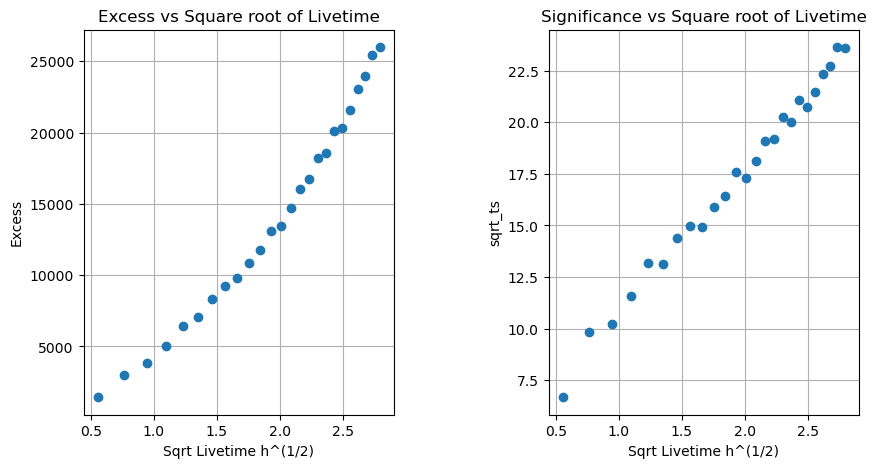

In [41]:
# Plot temporal evolution of excess events and significance value
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(
    np.sqrt(info_table["livetime"].to("h")), info_table["excess"], marker="o", ls="none"
)
plt.plot(info_table["livetime"].to("h")[-1:1], info_table["excess"][-1:1], 'r')
plt.xlabel("Sqrt Livetime h^(1/2)")
plt.ylabel("Excess")
plt.grid()
plt.title('Excess vs Square root of Livetime')

plt.subplot(122)
plt.plot(
    np.sqrt(info_table["livetime"].to("h")),
    info_table["sqrt_ts"],
    marker="o",
    ls="none",
)
plt.grid()
plt.xlabel("Sqrt Livetime h^(1/2)")
plt.ylabel("sqrt_ts")
plt.title('Significance vs Square root of Livetime')
plt.subplots_adjust(wspace=0.5)